# Characterizing errors in direct-$R_{zx}$ gates

- Use the sigma-adjusted version of linearized Rzx
- Calibrate the width-to-phi conversion by a Rabi fit
  - Allow for a offset $\phi_0$ because width 0 can still effect a rotation in the cancelling scheme
- Identify the width corresponding to $\phi = 0.1$ rotation, repeat the gate 10 times and compare the result with $R_{zx}(1)$

In [1]:
import re
import numpy as np
import scipy
from qiskit import IBMQ, QuantumCircuit, QuantumRegister, pulse, transpile
from qiskit.circuit import Gate

from pulse_experiment_utils import *
from calibrations import linearized_rzx

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='icepp')
backend = provider.get_backend('ibm_kawasaki')

In [3]:
control_qubit = 12
target_qubit = 13

backend_config = backend.configuration()
backend_defaults = backend.defaults()
calibrations = backend_defaults.instruction_schedule_map
cx_schedule = calibrations.get('cx', [control_qubit, target_qubit])

## Initial calibration

width -12 gs_duration 272 target 130.0 gs_sigma 62.896512847773295
width 25 gs_duration 288 target 131.5 gs_sigma 62.17127969993183
width 77 gs_duration 336 target 129.5 gs_sigma 63.15677732073462
width 88 gs_duration 352 target 132.0 gs_sigma 61.94662217544806
width 124 gs_duration 384 target 130.0 gs_sigma 62.896512847773295
width 156 gs_duration 416 target 130.0 gs_sigma 62.896512847773295
width 190 gs_duration 448 target 129.0 gs_sigma 63.42709166326603
width 233 gs_duration 496 target 131.5 gs_sigma 62.17127969993183
width 261 gs_duration 512 target 125.5 gs_sigma 65.64977296916145
width 275 gs_duration 528 target 126.5 gs_sigma 64.94909609563071
width 327 gs_duration 576 target 124.5 gs_sigma 66.4124980233577
width 361 gs_duration 624 target 131.5 gs_sigma 62.17127969993183
width 387 gs_duration 640 target 126.5 gs_sigma 64.94909609563071
width 422 gs_duration 672 target 125.0 gs_sigma 66.02291791351863
width 462 gs_duration 720 target 129.0 gs_sigma 63.42709166326603
width 481 g

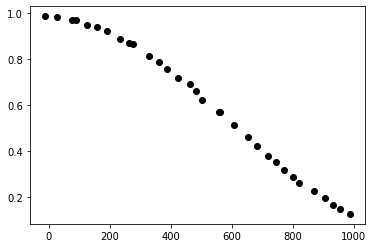

[0.00248078 0.05998476 0.47833924 0.50905554]


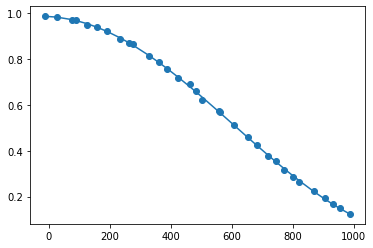

In [4]:
do_initial_calibration = True

cx_cr_pulse = get_instruction_by_name(cx_schedule, r'CR90p_u[0-9]+$').pulse

if do_initial_calibration:
    width_values = np.arange(0, 2 * cx_cr_pulse.width + 1, 32)
    for i in range(width_values.shape[0]):
        width_values[i] += np.random.randint(-16, 16)
    
    circuits = []
    for width in width_values:
        circuit = linearized_rzx(width, cx_schedule, lambda width: width, backend, adjust_sigma=True)
        circuit.measure_all()
        circuits.append(circuit)

    circuits = transpile(circuits, backend=backend, initial_layout=[control_qubit, target_qubit])

    job = backend.run(circuits, shots=8192)
    print(job.job_id())

    job_monitor(job)
    
    result = job.result()

    y_values = plot_counts(result, ['00', '01'], x=width_values)

    init_params = [np.pi / 900., 0., 0.5, 0.5]
    fitparams, conv = scipy.optimize.curve_fit(lambda width, v, phi0, amp, offset: offset + amp * np.cos(width * v + phi0), width_values, y_values, init_params)

    print(fitparams)

    plt.scatter(width_values, y_values)
    plt.plot(width_values, fitparams[3] + fitparams[2] * np.cos(fitparams[0] * width_values + fitparams[1]))
    plt.show()
    
    v, phi0, amp, offset = fitparams
    
else:
    v, phi0, amp, offset = [0.00256278, 0.06618242, 0.47014541, 0.52643327]

### What is the relation between the deviation and the width perturbation?

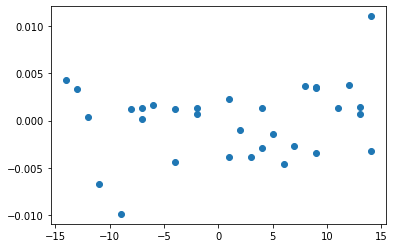

In [5]:
deviation = y_values - (offset + amp * np.cos(v * width_values + phi0))
perturbation = width_values - np.arange(0, 2 * cx_cr_pulse.width + 1, 32)
plt.scatter(perturbation, deviation)

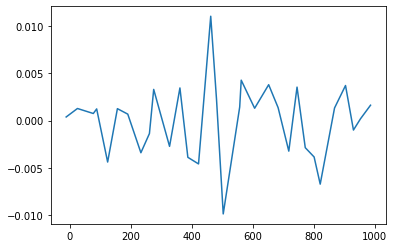

In [7]:
plt.plot(width_values, deviation)

### With no adjustment of sigma?

615d5353ce0f4fb404f22d8f
Job Status: job has successfully run


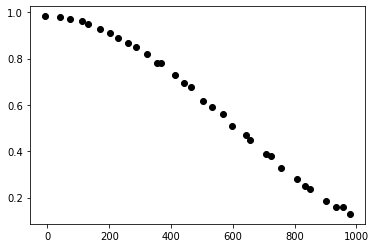

[0.00253002 0.05802772 0.46912718 0.51636461]


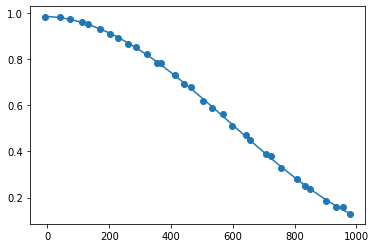

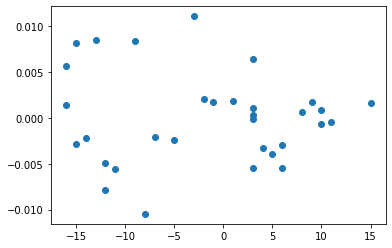

In [8]:
try_no_sigma_adjustment = False

if try_no_sigma_adjustment:
    circuits = []
    for width in width_values:
        circuit = linearized_rzx(width, cx_schedule, lambda width: width, backend, adjust_sigma=False)
        circuit.measure_all()
        circuits.append(circuit)

    circuits = transpile(circuits, backend=backend, initial_layout=[control_qubit, target_qubit])

    #job = backend.run(circuits, shots=8192)
    #print(job.job_id())

    #job_monitor(job)

    ## NOTE: This job used a different width_values array (np.random was a bad idea)
    job = backend.retrieve_job('615d5353ce0f4fb404f22d8f')

    result = job.result()

    y_values = plot_counts(result, ['00', '01'], x=width_values)

    init_params = [np.pi / 900., 0., 0.5, 0.5]
    fitparams, conv = scipy.optimize.curve_fit(lambda width, v, phi0, amp, offset: offset + amp * np.cos(width * v + phi0), width_values, y_values, init_params)

    print(fitparams)

    v, phi0, amp, offset = fitparams

    curve = offset + amp * np.cos(v * width_values + phi0)

    plt.scatter(width_values, y_values)
    plt.plot(width_values, curve)
    plt.show()

    deviation = y_values - curve
    perturbation = width_values - np.arange(0, 2 * cx_cr_pulse.width + 1, 32)
    plt.scatter(perturbation, deviation)

## Error accumulation experiment

width 16.130092581386958 gs_duration 272 target 127.93495370930653 gs_sigma 64.03883901837472
width 16.130092581386958 gs_duration 272 target 127.93495370930653 gs_sigma 64.03883901837472
width 56.439965170287024 gs_duration 320 target 131.7800174148565 gs_sigma 62.044469537096326
width 96.7498377591871 gs_duration 352 target 127.62508112040645 gs_sigma 64.22663195673803
width 137.05971034808715 gs_duration 400 target 131.47014482595642 gs_sigma 62.18495186592082
width 177.3695829369872 gs_duration 432 target 127.3152085315064 gs_sigma 64.4191149489939
width 217.67945552588725 gs_duration 480 target 131.16027223705638 gs_sigma 62.32861923599211
width 257.9893281147873 gs_duration 512 target 127.00533594260634 gs_sigma 64.61644777115818
width 298.2992007036874 gs_duration 560 target 130.8503996481563 gs_sigma 62.47556670767455
width 338.6090732925874 gs_duration 592 target 126.69546335370629 gs_sigma 64.81879759172844
width 378.9189458814875 gs_duration 640 target 130.54052705925625 gs_

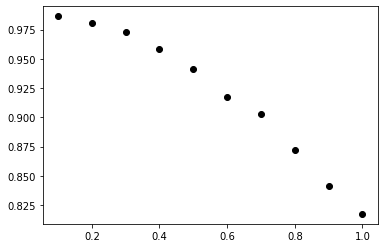

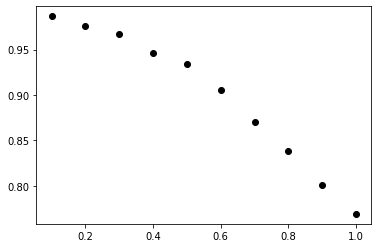

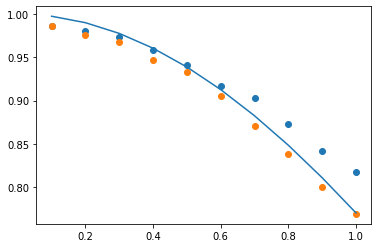

In [6]:
rzx_circuit = linearized_rzx(0.1, cx_schedule, lambda phi: (phi - phi0) / v, backend, adjust_sigma=True)

circuits = []

for nrep in range(1, 11):
    circuit = QuantumCircuit(rzx_circuit.qregs[0])
    for _ in range(nrep):
        circuit.compose(rzx_circuit, inplace=True)
    circuit.measure_all()
    circuits.append(circuit)
    
for phi_value in np.linspace(0.1, 1., 10):
    circuit = linearized_rzx(phi_value, cx_schedule, lambda phi: (phi - phi0) / v, backend, adjust_sigma=True)
    circuit.measure_all()
    circuits.append(circuit)
    
circuits = transpile(circuits, backend=backend, initial_layout=[control_qubit, target_qubit])

job = backend.run(circuits, shots=8192)
print(job.job_id())

job_monitor(job)

result = job.result()

x_values = np.linspace(0.1, 1., 10)
y_incr = plot_counts(result, ['00', '01'], x=x_values, indices=np.arange(10))
y_direct = plot_counts(result, ['00', '01'], x=x_values, indices=np.arange(10, 20))
plt.scatter(x_values, y_incr)
plt.scatter(x_values, y_direct)
plt.plot(x_values, 0.5 * np.cos(x_values) + 0.5)

Error accumulates quite significantly

## Error accumulation with pulse-efficient scheme

In [17]:
rzx_circuit = pulse_efficient_rzx(0.1, cx_schedule, backend)

circuits = []

for nrep in range(1, 11):
    circuit = QuantumCircuit(rzx_circuit.qregs[0])
    for _ in range(nrep):
        circuit.compose(rzx_circuit, inplace=True)
    circuit.measure_all()
    circuits.append(circuit)
    
for phi_value in np.linspace(0.1, 1., 10):
    circuit = pulse_efficient_rzx(phi_value, cx_schedule, backend)
    circuit.measure_all()
    circuits.append(circuit)
    
circuits = transpile(circuits, backend=backend, initial_layout=[control_qubit, target_qubit])

#job = backend.run(circuits, shots=8192)
#print(job.job_id())

#job_monitor(job)

job = backend.retrieve_job('615c6b0e8fd55f06b9fac621')

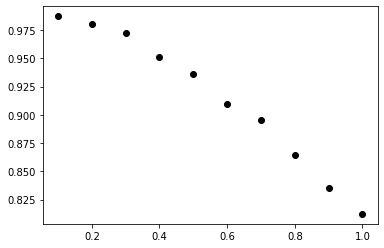

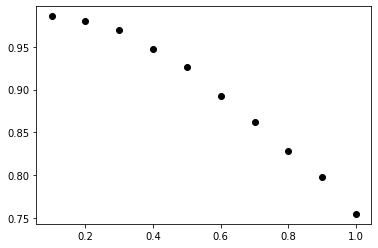

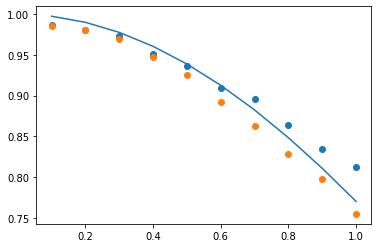

In [18]:
result = job.result()

x_values = np.linspace(0.1, 1., 10)
y_incr = plot_counts(result, ['00', '01'], x=x_values, indices=np.arange(10))
y_direct = plot_counts(result, ['00', '01'], x=x_values, indices=np.arange(10, 20))
plt.scatter(x_values, y_incr)
plt.scatter(x_values, y_direct)
plt.plot(x_values, 0.5 * np.cos(x_values) + 0.5)

## Error accumulation with CNOT

In [19]:
circuits = []

for nrep in range(1, 11):
    circuit = QuantumCircuit(2)
    for _ in range(nrep):
        circuit.rzx(0.1, 0, 1)
        circuit.barrier()
    circuit.measure_all()
    circuits.append(circuit)
    
circuits = transpile(circuits, backend=backend, initial_layout=[control_qubit, target_qubit])

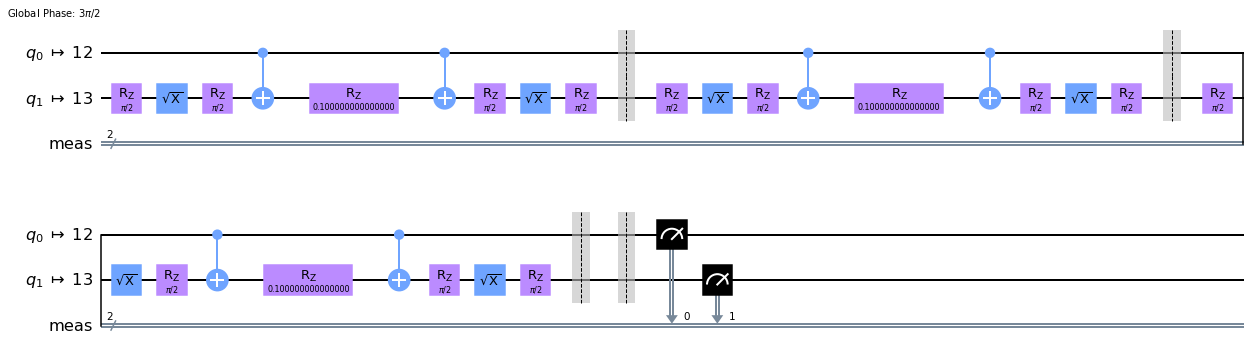

In [24]:
circuits[2].draw('mpl', idle_wires=False)

In [21]:
#job = backend.run(circuits, shots=8192)
#print(job.job_id())

#job_monitor(job)

In [22]:
job = backend.retrieve_job('615c081520df541a775e42a7')

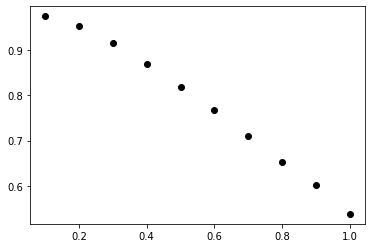

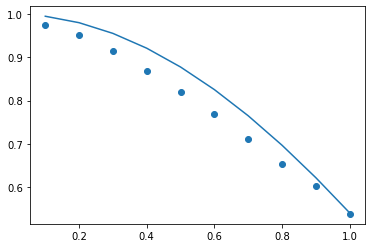

In [23]:
result = job.result()

x_values = np.linspace(0.1, 1., 10)
y_values = plot_counts(result, ['00', '01'], x=x_values)
plt.scatter(x_values, y_values)
plt.plot(x_values, np.cos(x_values))